# Laplacian experiment

In [215]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

from network import LPN
from utils import prox, cvx, prior, gt_cvx, soft_thr

sns.set()

MODEL_DIR = "experiments/models/"
os.makedirs(MODEL_DIR, exist_ok=True)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# set seed
np.random.seed(1)
torch.manual_seed(1)

## Define distribution

In [216]:
dim = 1

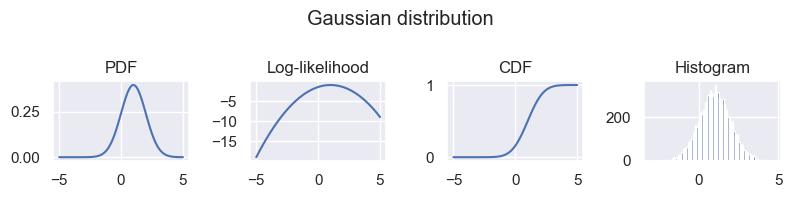

In [217]:
# Sample data points from Laplacian distribution:
# exp(-|x-mu|^2/2(sigma^2)) / sqrt((2pisigma^2))
def sample_gaussian(n, mu, sigma):
    """
    Inputs:
        n:  number of points
        mu:     mean
        sigma:  standard deviation
    Outputs:
        x: a vector of n points, torch.tensor
    """
    x = torch.distributions.normal.Normal(mu, sigma).sample((n,))
    return x


class GaussianSampler(object):
    def __init__(self, mu, sigma):
        self.mu = mu
        self.sigma = sigma

    def __call__(self, n):
        return sample_gaussian(n, self.mu, self.sigma)


mu = 1.0
sigma = 1.0
dist = torch.distributions.normal.Normal(mu, sigma)
x = GaussianSampler(mu, sigma)(10000)
# plot pdf, log-likelihood, cdf
plt.rcParams["figure.figsize"] = (8, 2)
x = torch.linspace(-5, 5, 100)
plt.subplot(1, 4, 1)
plt.plot(x, dist.log_prob(x).exp())
plt.title("PDF")
plt.subplot(1, 4, 2)
plt.plot(x, dist.log_prob(x))
plt.title("Log-likelihood")
plt.subplot(1, 4, 3)
plt.plot(x, dist.cdf(x))
plt.title("CDF")
plt.subplot(1, 4, 4)
plt.hist(sample_gaussian(10000, mu, sigma), bins=100)
plt.title("Histogram")
plt.suptitle("Gaussian distribution")
plt.tight_layout()

In [218]:
# Add noise to the data
def add_noise(x, sigma=0.1):
    """
    Inputs:
        x: a vector of n points, torch.tensor
        sigma: standard deviation of the noise
    Outputs:
        x: a vector of n points, torch.tensor
    """
    noise = torch.randn_like(x) * sigma
    return x + noise

In [219]:
# parameters for laplace distribution
mu = 1.0
sigma = 1.0
sigma_noise = 1.0
sampler = GaussianSampler(mu, sigma)

Text(0.5, 1.0, 'Example training points')

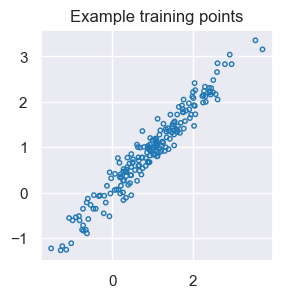

In [220]:
# example training points
target = sampler(200).unsqueeze(1)
input = add_noise(target, sigma_noise)
plt.rcParams["figure.figsize"] = (3, 3)
plt.scatter(input, target, s=10, facecolors="none", edgecolors="tab:blue")
plt.grid("on")
plt.title("Example training points")

### Plot function

In [221]:
# function to plot learned prox, convex function, original function
def plot_all(model):
    xi = np.linspace(-4, 4, 1000)

    y = prox(xi, model)
    c = cvx(xi, model)
    p = prior(xi, model)

    plt.rcParams["figure.figsize"] = (8, 3)

    # True proximal operator
    prox_true = (sigma*xi + mu)/(1+sigma)

    # learned prox
    plt.subplot(1, 3, 1)
    plt.plot(xi, y, "-", ms=5, label="LPN")
    plt.plot(xi, prox_true, "--", label="tikhonov.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Learned prox")

    # convex function
    plt.subplot(1, 3, 2)
    plt.plot(xi, c - c.min(), "-", ms=5, label="Cvx func")
    # plt.plot(xi, gt_cvx(xi), "--", label="ref.", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Cvx func")

    # original function
    plt.subplot(1, 3, 3)
    plt.plot(xi, p - p.min(), label="LPN")
    plt.plot(xi, 0.5*np.square(xi- mu)/np.square(sigma,2), "--", label=r"$\ell_{2}^{2}$", zorder=1.9)
    plt.grid("on")
    plt.legend()
    plt.title("Original func")

    plt.tight_layout()

## Define loss

Text(0.5, 1.0, 'exp loss')

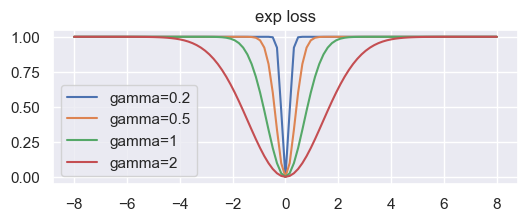

In [222]:
# proximal matching loss: -exp(-(x/gamma)^2) + 1
def exp_func(x, gamma):
    return -torch.exp(-((x / gamma) ** 2)) + 1


# visualize the loss at different sigma
plt.rcParams["figure.figsize"] = (6, 2)
x = torch.linspace(-8, 8, 101)
for gamma_exp_loss in [0.2, 0.5, 1, 2]:
    plt.plot(x, exp_func(x, gamma_exp_loss), label="gamma=" + str(gamma_exp_loss))
plt.legend()
plt.grid("on")
plt.title("exp loss")

## Model parameters

In [223]:
beta = 10  # beta of softplus
hidden = 50  # number of hidden units
layers = 4  # number of layers

# create a model
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
print(
    "Number of parameters in ICNN",
    sum(p.size().numel() for p in lpn_model.parameters()),
)

Number of parameters in ICNN 10502


## Training function

In [224]:
def single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss=None):
    target = sampler(bsize).unsqueeze(1)
    input = add_noise(target, sigma_noise)
    
    input, target = input.to(device), target.to(device)
    out = lpn_model(input)

    if loss_type == 2:
        loss = (out - target).pow(2).sum() / bsize  # MSE loss
    elif loss_type == 1:
        loss = (out - target).abs().sum() / bsize  # MAE loss
    elif loss_type == 0:
        loss = exp_func(out - target, gamma_loss).mean()  # proximal matching loss
    else:
        raise ValueError("loss_type must be 0, 1, or 2")

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    lpn_model.wclip()

    # monitor
    # loss_lstar = exp_func(out - target, 0.1).mean()

    if not i % 500:
        print("iteration", i, "loss", loss.item()) #, "loss_lstar", loss_lstar.item())

# Train

L2 loss

In [225]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 1000

for i in range(1):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=2)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l2.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

iteration 0 loss 2.965609550476074
iteration 0 loss 6.199762344360352
iteration 500 loss 0.20708850026130676
iteration 1000 loss 0.11178833246231079
iteration 1500 loss 0.09715057909488678


KeyboardInterrupt: 

L1 loss

In [140]:
# initialize
lpn_model = LPN(in_dim=dim, hidden=hidden, layers=layers, beta=beta).to(device)
optimizer = torch.optim.Adam(lpn_model.parameters(), lr=1e-3)
bsize = 1000

for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)

for g in optimizer.param_groups:
    g["lr"] = 1e-4
for i in range(10000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type=1)


# save the model
torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, "l1.pth"))

plot_all(lpn_model)
print(
    "Values at [-3,-2,-1,0,1,2,3]:",
    lpn_model(
        torch.tensor([-3, -2, -1, 0, 1, 2, 3]).unsqueeze(1).float().to(device)
    ).squeeze(1),
)

torch.Size([1000, 1])
torch.Size([1000, 1])
iteration 0 loss 1.258962631225586
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1])
torch.Size([1000, 1

KeyboardInterrupt: 

## Proximal matching loss

gamma=0.5

torch.Size([200, 1])
torch.Size([200, 1])
iteration 0 loss 0.18877793848514557
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1

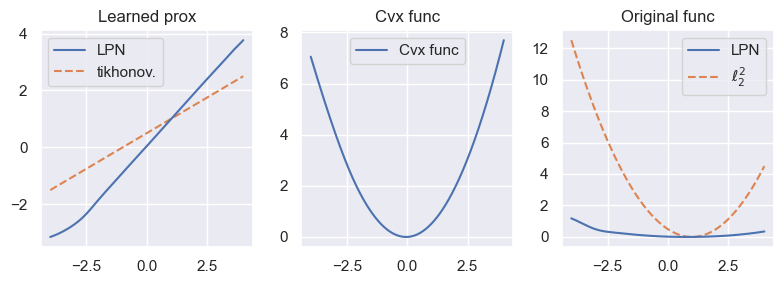

In [125]:
loss_type = 0
gamma_loss = 0.5

# set learning rate
for g in optimizer.param_groups:
    g["lr"] = 1e-3

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(2000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.4

torch.Size([200, 1])
torch.Size([200, 1])
iteration 0 loss 0.22588902711868286
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1

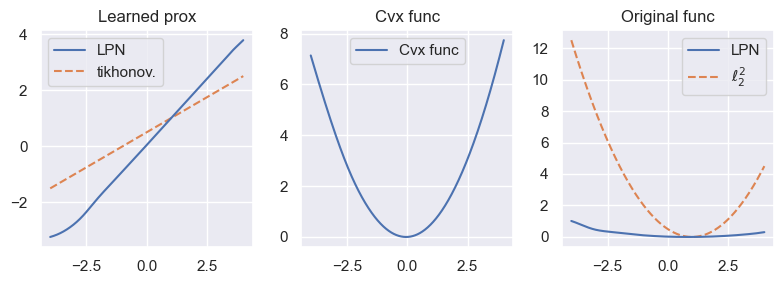

In [126]:
gamma_loss = 0.4
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.3

torch.Size([200, 1])
torch.Size([200, 1])
iteration 0 loss 0.36652103066444397
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1

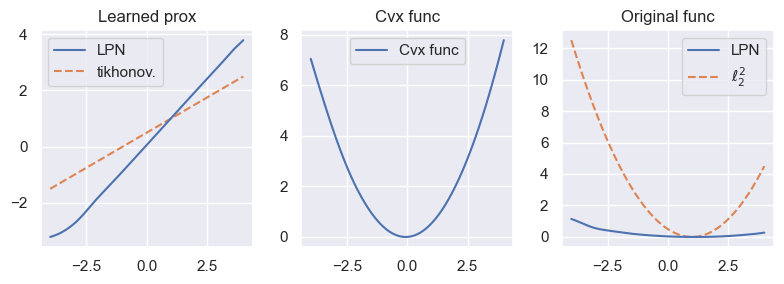

In [127]:
gamma_loss = 0.3
for g in optimizer.param_groups:
    g["lr"] = 1e-4

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

gamma=0.2

In [128]:
gamma_loss = 0.2
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)

torch.Size([200, 1])
torch.Size([200, 1])
iteration 0 loss 0.49248984456062317
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1])
torch.Size([200, 1

KeyboardInterrupt: 

gamma=0.1

mse 5.344014644622803
mse 4.508235454559326
mse 1.027532935142517
mse 0.2782607078552246
mse 0.07309245318174362
mse 0.009810972027480602
mse 0.0016254159854725003
mse 0.0002162798773497343
mse 2.173220127588138e-05
mse 1.8400311319055618e-06
final mse 1.336759396508569e-07
(1000,) (1000,) (1000,) (1000,)


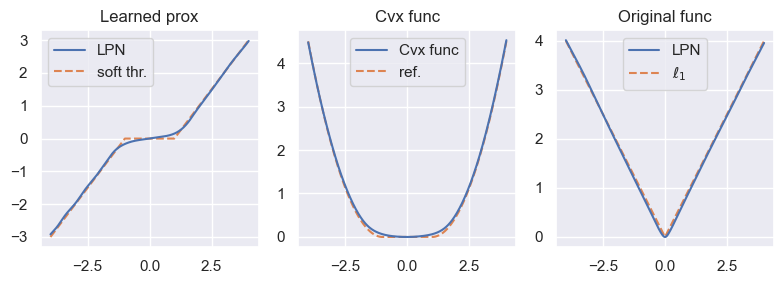

In [17]:
gamma_loss = 0.1
for g in optimizer.param_groups:
    g["lr"] = 1e-5

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

for g in optimizer.param_groups:
    g["lr"] = 1e-6

for i in range(4000):
    single_iteration(i, bsize, sigma_noise, optimizer, loss_type, gamma_loss)

torch.save(lpn_model.state_dict(), os.path.join(MODEL_DIR, f"l_{gamma_loss}.pth"))

plot_all(lpn_model)